In [35]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt


In [36]:

class NaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

        self.classes_likelihoods = {}

    def build_classifier(self, train_features, train_classes, interval_count, classess_count):
        discrete_features = self.data_discretization(train_features, interval_count)
        attr_length = len(discrete_features[0])
        data_length = len(train_features)
        classes_counter = Counter(train_classes)
        for i in range(classess_count):
            self.likelihoods[i] = {}
            self.classes_likelihoods[i] = classes_counter[i] / data_length
            features_for_class = []
            for j in range(data_length):
                if train_classes[j] == i:
                    features_for_class.append(discrete_features[j])
            for j in range(attr_length):
                list = [value[j] for value in features_for_class]
                attrs_likelihoods = Counter(list)
                for k in range(attr_length):
                    try:
                        attrs_likelihoods[k] = attrs_likelihoods[k] / classes_counter[i]
                    except KeyError:
                        attrs_likelihoods[k] = 0
                self.likelihoods[i][j] = attrs_likelihoods

    @staticmethod
    def data_discretization(data, interval_count):
        discrete_data = []
        borders_lists = []
        data_length = len(data)
        attr_length = len(data[0])
        for i in range(attr_length):
            list = [value[i] for value in data]
            list.sort()
            borders = []
            for i in range(interval_count - 1):
                borders.append(list[int(data_length*(i+1)/interval_count)])
            borders_lists.append(borders)

        for record in data:
            discrete_record = []
            for i in range(attr_length):
                value = record[i]
                for j in range(interval_count - 1):
                    added = False
                    if value <= borders_lists[i][j] and not added:
                        discrete_record.append(j)
                        added = True
                        break
                    elif value > borders_lists[i][-1] and not added:
                        discrete_record.append(interval_count-1)
                        added = True
                        break
            discrete_data.append(discrete_record)
        return discrete_data



    def predict(self, sample):
        likelihoods = {}
        sum = 0
        for i in range(len(self.classes_likelihoods)):
            class_likelihood = self.classes_likelihoods[i]
            for j in range(len(sample)):
                class_likelihood = class_likelihood * self.likelihoods[i][j][sample[j]]
                # sum of log values instead of multiplications could be used
            sum += class_likelihood
            likelihoods[i] = class_likelihood
        return likelihoods # likelihoods are not normalized -> not adding up to 1

class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

        self.classes_likelihoods = {}

    def build_classifier(self, train_features, train_classes, classess_count):
        attr_length = len(train_features[0])
        data_length = len(train_features)
        classes_counter = Counter(train_classes)
        for i in range(classess_count):
            self.likelihoods[i] = {}
            self.classes_likelihoods[i] = classes_counter[i] / data_length
            features_for_class = []
            for j in range(data_length):
                if train_classes[j] == i:
                    features_for_class.append(train_features[j])
            for j in range(attr_length):
                self.likelihoods[i][j] = {}
                list = [value[j] for value in features_for_class]
                self.likelihoods[i][j]['mean'] = np.mean(list)
                self.likelihoods[i][j]['std'] = np.std(list)


    @staticmethod
    def normal_dist(x, mean, std):
        return (1.0 / (std * math.sqrt(2*math.pi))) * math.exp(-0.5*((x - mean) / std) ** 2)


    def predict(self, sample):
        likelihoods = {}
        likelihoods_normalized = {}
        sum = 0
        for i in range(len(self.classes_likelihoods)):
            class_likelihood = self.classes_likelihoods[i]
            for j in range(len(sample)):

                mean = self.likelihoods[i][j]['mean']
                std = self.likelihoods[i][j]['std']
                class_likelihood = class_likelihood * self.normal_dist(sample[j], mean, std)

            sum += class_likelihood
            likelihoods[i] = class_likelihood
        for i in range(len(self.classes_likelihoods)):
            likelihoods_normalized[i] = likelihoods[i] / sum
        return likelihoods_normalized

In [46]:
def tester(bayes, x_test, y_test, verbose):
    predictions = []
    for sample, gt in zip(x_test, y_test):
        likelihoods = bayes.predict(sample)
        prediction = max(likelihoods, key=likelihoods.get)
        predictions.append(prediction)
        if verbose == 2:
            print(f'Prediction: {predictions[-1]}; Real class: {gt}')
    accuracy = np.mean(predictions == y_test)
    if verbose in [1, 2]:
        print(f"Accuracy: {accuracy}")
    return accuracy


def plotter(bayes, params_list, discrete, classes_count, iris_data, iris_target, verbose):
    iter = 0
    mean_accuracies = []
    for param in params_list:
        accuracies = []
        for i in range(500):
            if not discrete:
                x_train, x_test, y_train, y_test = train_test_split(iris_data, iris_target, test_size=param) #random states
                bayes.build_classifier(x_train, y_train, classes_count)
            else:
                x_train, x_test, y_train, y_test = train_test_split(iris_data, iris_target, test_size=0.1) #random states
                bayes.build_classifier(x_train, y_train, param, classes_count)
                x_test = bayes.data_discretization(x_test, param)
            accuracy = tester(bayes, x_test, y_test, verbose)
            accuracies.append(accuracy)
        mean_accuracies.append(np.mean(accuracies))
        if verbose == 1:
            print(f"Accuracy: {mean_accuracies[iter]}")
        iter += 1
    plt.plot(params_list, mean_accuracies)
    plt.scatter(params_list, mean_accuracies)
    if discrete:
        plt.title("Discrete Naive Bayes")
        plt.xlabel("Intervals count")
    else:
        plt.title("Gaussian Naive Bayes")
        plt.xlabel("Test sizes")
    plt.ylabel("Accuracy")
    plt.show()



In [43]:
iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

classes_count = 3
verbose = 2
intervals = 4

gaussian_naive_bayes = GaussianNaiveBayes()
disc_naive_bayes = NaiveBayes()

disc_naive_bayes.build_classifier(x_train, y_train, intervals, classes_count)
x_test_discrete = disc_naive_bayes.data_discretization(x_test, intervals)

gaussian_naive_bayes.build_classifier(x_test, y_test, classes_count)


print("Discrete Naive Bayes:\n")
tester(disc_naive_bayes, x_test_discrete, y_test, 2)

print("\nGaussian Naive Bayes:\n")
tester(gaussian_naive_bayes, x_test, y_test, 2)

Discrete Naive Bayes:

Prediction: 1; Real class: 1
Prediction: 1; Real class: 2
Prediction: 2; Real class: 2
Prediction: 1; Real class: 1
Prediction: 0; Real class: 0
Prediction: 1; Real class: 2
Prediction: 1; Real class: 1
Prediction: 0; Real class: 0
Prediction: 0; Real class: 0
Prediction: 1; Real class: 1
Prediction: 2; Real class: 2
Prediction: 0; Real class: 0
Prediction: 1; Real class: 1
Prediction: 1; Real class: 2
Prediction: 2; Real class: 2
Accuracy: 0.8

Gaussian Naive Bayes:

Prediction: 1; Real class: 1
Prediction: 2; Real class: 2
Prediction: 2; Real class: 2
Prediction: 1; Real class: 1
Prediction: 0; Real class: 0
Prediction: 2; Real class: 2
Prediction: 1; Real class: 1
Prediction: 0; Real class: 0
Prediction: 0; Real class: 0
Prediction: 1; Real class: 1
Prediction: 2; Real class: 2
Prediction: 0; Real class: 0
Prediction: 1; Real class: 1
Prediction: 2; Real class: 2
Prediction: 2; Real class: 2
Accuracy: 1.0


1.0

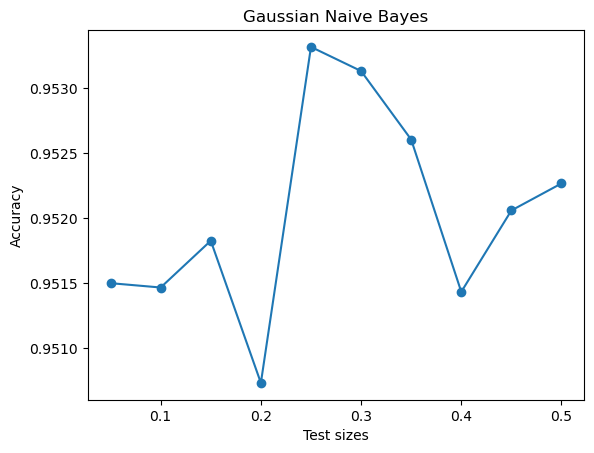

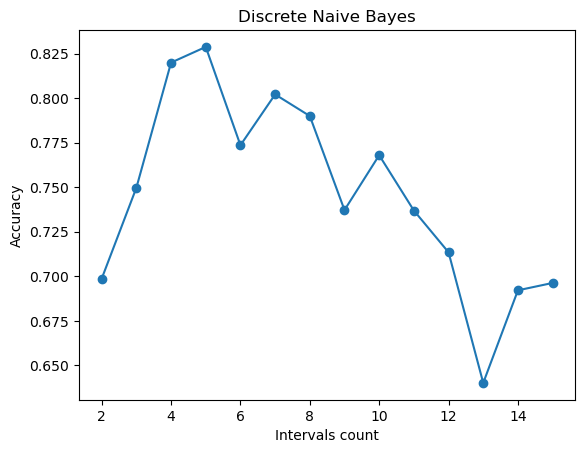

In [49]:
iris = load_iris()

x = iris.data
y = iris.target

gaussian_naive_bayes = GaussianNaiveBayes()
disc_naive_bayes = NaiveBayes()

classes_count = 3
verbose = 0
test_sizes = [(i+1)*0.05 for i in range(10)]
intervals_counts = [i for i in range(16) if i > 1]

plotter(gaussian_naive_bayes, test_sizes, 0, classes_count, x, y, 0)
plotter(disc_naive_bayes, intervals_counts, 1, classes_count, x, y, 0)

test_sizes = [(i+1)*0.05 for i in range(18)]
plotter(gaussian_naive_bayes, test_sizes, 0, classes_count, x, y, 0)


Wnioski:

W przypadku dyskretnej wersji klasyfikatora ilość interwałów ma zauważalny wpływ i dla uśrednionej wartości dokładności optimum uzyskiwane jest dla 4 przedziałów dla podanego benchmarku. Niemniej nie jest to realnie porównywalny wynik z klasyfiaktorem Gaussowskim, który zaś osiąga dokładności rzędu 0.93-0.96, co można uznać za wynik bardzo dobry przy tym jak łatwa jest implementacja naiwnego klasyfikatora bayesowskiego względem chociażby drzewa decyzyjnego ID3, czy sieciach neuronowych. Pokazuje to potencjał tej metody do prostych problemów, lecz zakłada fundamentalne uproszczenie, czyli niezależność cech, co może znacząco wpłynąć na jego jakość dla bardziej złożonych zastosowań. Dodatkowo warto zaznaczyć, że wielkość zbioru testowego nie wpływa w znaczny sposób na jakoś algorytmu, aż do wartości 0.8-0.9, co jest dość niespodziewanym w ogólności wynikiem, lecz może to być wynik szczególnego rozkładu danych w wykorzystanym benchmarku. 